In [ ]:
%load_ext autoreload
%autoreload 2

# Task 3: Eigenfaces & Fischerfaces (3 pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   Mykhailo Pavliuk
*   Volodymyr Leha


In this task your main goal is to discuss dimensionality reduction techniques, such as **PCA** and **LDA** and their performance on classification tasks.

A good source to read more on these methods is the book

*   Kevin P. Murphy. [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html), MIT, 2022. Section 9.2.6 (FLDA), 20.1 (PCA and Eigenfaces)



## 1. Lib and Data prep (0.5 pts)
#### Let's start with importing all neccesary libraries and preparing our data

In [ ]:
from PIL import Image
from sklearn.datasets import fetch_lfw_people
import numpy as np
from sklearn.svm import SVC
import sklearn
from matplotlib import pyplot as plt
import scipy

Seed libs, so we get the same results every time:

In [ ]:
sklearn.random.seed(1)
np.random.seed(1)

Fetch data and split them into training and test sets:

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.3)
n,h,w = lfw_people.images.shape
labels = lfw_people.target

class1, class2 = 3, 4 # choose your preferred classes, make sure that there is almost equal number of samples for each class

x= lfw_people.data[(labels == class1)|(labels==class2)]
y = labels[(labels == class2)|(labels==class1)]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25) # split data using sklearn library
x_train.shape, x_test.shape

((189, 1036), (64, 1036))

Visualise Your data:

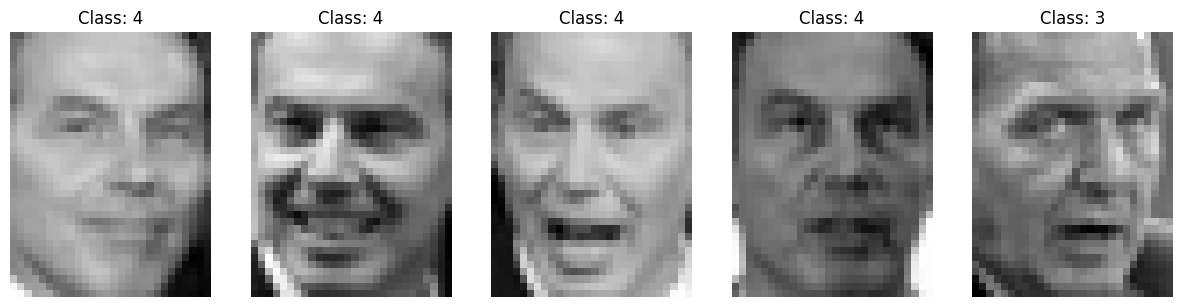

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #
def show_images(x, y, n=5):
  fig, axes = plt.subplots(1, n, figsize=(15, 4))
  for i in range(n):
    idx = np.random.randint(0, len(x))
    img = x[idx].reshape(h, w)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Class: {y[idx]}")
    axes[i].axis('off')

  plt.show()

show_images(x_train, y_train)

# ========== YOUR CODE ENDS HERE ========== #

## 2. PCA (1.5 pts)


### **2.1 (0.7 pt) Implementation**
Let's start implementing the **PCA** algorithm

In [ ]:
class MYPCA:
    def __init__(self) -> None:
        self._data_mean = None
        self.eigenvalues = None
        self.eigenvectors = None
        self._k_components = None
        self.components = None

    def _get_num_components(self, lambdas, threshold ) -> int:
        """
        Calculate minimal number of principal components so that variance explainability >= threshold.
        """
         # ========= YOUR CODE STARTS HERE ========= #
        lambdas = np.sort(lambdas)[::-1]
        total_variance = np.sum(lambdas)
        cumulative_variance = np.cumsum(lambdas) / total_variance

        for k, cumulative in enumerate(cumulative_variance, start=1):
            if cumulative >= threshold:
                return k
         # ========== YOUR CODE ENDS HERE ========== #

    def center_data(self, data):
        """
        Center our data by subtracting the mean
        """
         # ========= YOUR CODE STARTS HERE ========= #

        self._data_mean = np.mean(data, axis=0)
        return data - self._data_mean
         # ========== YOUR CODE ENDS HERE ========== #


    def compute_eigen(self, cov_mat):
        """
        Using built-in numpy functionality, compute eigenvectors and eigenvalues of covariance matrix;
        """
        # ========= YOUR CODE STARTS HERE ========= #
        eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        return eigenvalues, eigenvectors
        # ========== YOUR CODE ENDS HERE ========== #


    def fit(self, data, exp_threshold=0.8):
        """
        1. Center the data;
        2. Compute covariance matrix
        3. Compute optimal k (number of components)
        4. Compute top-k eigenvalues from covariance matrix
        5. Compute components by projecting data with eigenvectors
        """
        # ========= YOUR CODE STARTS HERE ========= #

        data_norm = self.center_data(data)
        cov_mat = np.cov(data_norm, rowvar=False)
        self.eigenvalues, self.eigenvectors = self.compute_eigen(cov_mat=cov_mat)
        self._k_componentes = self._get_num_components(self.eigenvalues, exp_threshold)

        top_k_values = self.eigenvalues[:self._k_components]
        top_k_vectors = self.eigenvectors[:, :self._k_components]
        self.components = data_norm.dot(top_k_vectors)
        # ========== YOUR CODE ENDS HERE ========== #


    def plot_components(self, im_shape, n_components=5):
        """
        For better understanding, visualise the *self.components* variable.
        """
        # ========= YOUR CODE STARTS HERE ========= #
        components = self.components[:n_components]
        fig, axes = plt.subplots(1, n_components, figsize=(15, 4))
        for i, component in enumerate(components):
            component_image = component.reshape(im_shape)
            component_image = (component_image - component_image.min()) / (component_image.max() - component_image.min())
            axes[i].imshow(component_image, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"Component {i + 1}")

        plt.show()
        # ========== YOUR CODE ENDS HERE ========== #

    def plot_explainability(self):
        """
        Plot dependence of variance explainability on number of components.
        """
        # ========= YOUR CODE STARTS HERE ========= #
        explained_variance = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)
        plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Explained Variance vs Number of Components")
        plt.grid(True)
        plt.show()
        # ========== YOUR CODE ENDS HERE ========== #

    def transform(self, data):
        """
        1. Center the data;
        2. Projection onto the components
        """
        # ========= YOUR CODE STARTS HERE ========= #

        data_norm = self.center_data(data)
        return data_norm.dot(self.eigenvectors[:, :self._k_components])
        # ========== YOUR CODE ENDS HERE ========== #





### **2.2 PCA Classifier (0.4 pts)**
Having implemented the **MYPCA** class, let's plot how our components look like and our explainability plot

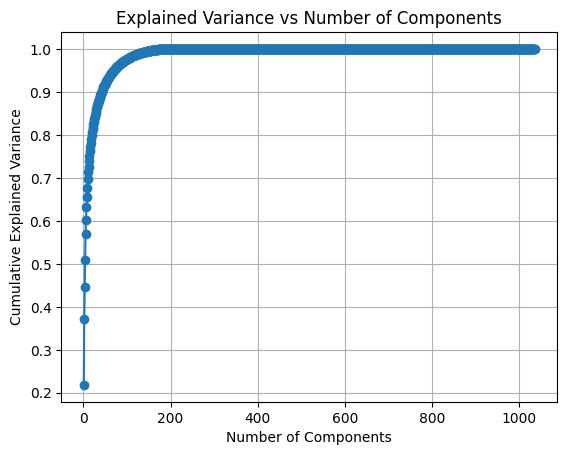

In [ ]:
pca = MYPCA()
pca.fit(x_train, exp_threshold=0.8)
pca.plot_explainability()

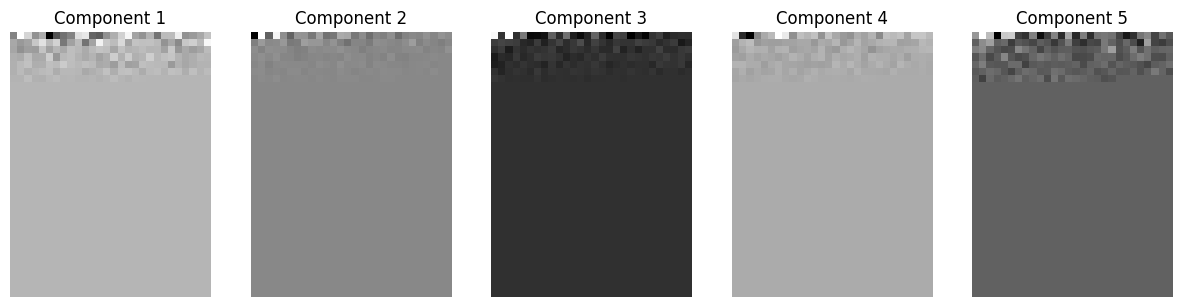

In [ ]:
pca.plot_components(im_shape=(37, 28))

Now, let's try to classify the data, using sklearn **SVC**.

In [ ]:
classifier = SVC().fit(pca.transform(x_train), y_train)
print(classifier.score(pca.transform(x_test), y_test))

0.796875


### **2.3. Discussion of the results (0.4 pts):**
1. What is the concept of variance explainability and why is it so important?
1. What is the optimal number of components to reach good enough classification performance and why?

---
#### **Your answer here:**
1. Variance explainability is a proportion of the total variance in the data by each component in PCA. When there are many features in the dataset, some of them might be redundant, the variance explainbility helps to ensure accuracy of the reduced representation of data.
2. The optimal number of components depends on the dataset. In general we want to find the number that captures enough variance (usually 90%), to have good accuracy. Less number of components can improve efficiency, but might lose critical information.
---

## 3. Fischerface classification and LDA (1 pt)
Now, having implemented the **PCA** algorithm, let's implement the **Linear Discriminant Analysis** algorithm.

By this [link](https://towardsdatascience.com/fishers-linear-discriminant-intuitively-explained-52a1ba79e1bb) you can read more about this algorithm.

In this task we will see how we can improve our classification using **LDA**.

### **3.1. (0.6 pt) Implementation**
Here you only need to compute the $\mathbf{\it{S_B}}$ and $\mathbf{\it{S_W}}$ covariance matrices, discussed in the source above, and select appropriate eigenvectors

In [ ]:
class MYLDA:

    def fit(self, data, data_labels, k_components):
        n_feats = data.shape[-1]
        SW = np.zeros((n_feats, n_feats))
        SB = np.zeros((n_feats, n_feats))
        mu = data.mean(0)

        # ========= YOUR CODE STARTS HERE ========= #

        for channel in np.unique(data_labels):
            class_data = data[data_labels == channel]
            class_mean = class_data.mean(0)
            class_size = class_data.shape[0]

            class_diff = class_data - class_mean
            SW += class_diff.T @ class_diff

            mean_diff = (class_mean - mu).reshape(-1, 1)
            SB += class_size * (mean_diff @ mean_diff.T)
        # ========== YOUR CODE ENDS HERE ========== #

        SW += 1e-6 * np.eye(SW.shape[0])  # This needed to avoid singular SW
        evals, evecs = scipy.linalg.eigh(SB, SW)
        sorted_indices = np.argsort(evals)[::-1]
        self.proj = evecs[:, sorted_indices[:k_components]] # sort eigenvectors by eigenvalues and selet top k eigenvectors

    def transform(self, data):
        return data @ self.proj


Here we will implement the class for the Fischerface algorithm, which basically uses an **LDA** on top of **PCA**, such that we will perform maximum dimensionality reduction for classification purposes:

In [ ]:
class FischerFaces:
    def __init__(self) -> None:
        """
        Initialize pca and lda
        """
        self.pca = MYPCA()
        self.lda = MYLDA()

    def fit(self, X,Y, threshold, lda_components):
        """
        Fit the fischerface algo:
        1. Fit PCA
        2. Reduce data dimensions with PCA
        3. Fit LDA
        """
        self.pca.fit(X)
        pca_trans = self.pca.transform(X)
        self.lda.fit( pca_trans,  Y , lda_components )

    def transform(self, X):
        """
        Transform the data by using fitted PCA and LDA
        """
        return self.lda.transform(X)

Now, let's try out our new classifier based on Fischerface algorithm.

*Hint*: select the number of LDA components equal to the number of classes

In [ ]:
f = FischerFaces()
f.fit(x_train, y_train, 0.9, 2)

classifier = SVC().fit(f.transform(x_train), y_train)
print(classifier.score(f.transform(x_test), y_test))

0.53125


### **2.2 Discussion (0.4 pts)**
Evaluate the results of Fishcerface classifier (LDA). Discuss whether it performs better than the classic Eigenface algorithm (PCA), and if so, why

PCA performed better than LDA by getting a score of 0.79, meanwhile LDA got only 0.53. Usually, LDA performs better as it maximazes the ratio of between class variance to within class variance. PCA captures overall data variance, and seems to be more suitable for this dataset.
